In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell


def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = current.read(f, 'json')


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == 'code' and cell.language == 'python':
                # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.input)
                # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


(259200, 2)
Largest TS: 5.19600800514236
5.20 & 41.00 & -0.50 \\ \hline
4.61 & 41.00 & 0.00 \\ \hline
4.16 & 327.00 & -66.50 \\ \hline
4.13 & 12.50 & -67.50 \\ \hline
4.00 & 2.00 & 1.50 \\ \hline
3.92 & 297.00 & 27.50 \\ \hline
3.89 & 355.50 & -38.50 \\ \hline
3.88 & 233.00 & 1.50 \\ \hline
3.87 & 299.00 & -18.00 \\ \hline
3.85 & 296.50 & -21.00 \\ \hline
3.79 & 13.50 & -22.50 \\ \hline
3.78 & 111.50 & -0.50 \\ \hline
3.77 & 40.50 & 0.00 \\ \hline
3.73 & 336.00 & -6.50 \\ \hline
3.70 & 143.00 & -30.00 \\ \hline
3.70 & 43.50 & -63.00 \\ \hline
3.69 & 297.50 & 27.50 \\ \hline
3.68 & 247.00 & -58.00 \\ \hline
3.68 & 30.50 & 68.50 \\ \hline
3.68 & 46.50 & 16.50 \\ \hline


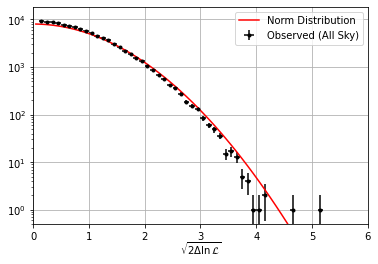

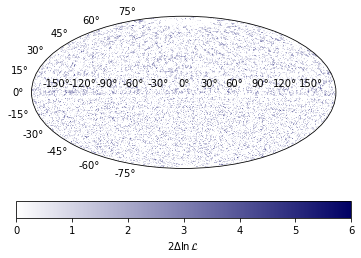

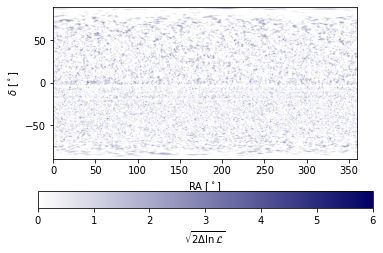

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
import IceCubeAnalysis


def main(fit_file_name, step_size=0.5):
    """
    Plots the results from the all-sky
    best-fit source search.
    Also prints out the most likely points on the sky.
    Parameters
    ----------
    fit_file_name : str
        Pickle file of the best-fit likelihood map.
    step_size : float
        The degrees step size to perform the all-sky search.
    """

    likelihood_map = np.load(fit_file_name,
                             allow_pickle=True)
    likelihood_map[likelihood_map <= 0.0] = 0.0

    cord_s, ra_len, dec_len = IceCubeAnalysis.prepare_skymap_coordinates(step_size)
    print(cord_s.shape)
    every_pt = np.reshape(cord_s, (ra_len, dec_len, cord_s.shape[-1]))

    sqrt_ts = np.sqrt(2.0 * likelihood_map)
    sqrt_ts[np.abs(every_pt[:, :, 1]) > 87.0] = 0.0

    print("Largest TS:", np.max(sqrt_ts))

    # Printout used to import table into Latex
    index_of_best = np.argsort(-1 * sqrt_ts.flatten())
    for i in index_of_best[:20]:
        print("%.2f & %.2f & %.2f \\\\ \hline" % (sqrt_ts.flatten()[i],
                                                  every_pt[:, :, 0].flatten()[i],
                                                  every_pt[:, :, 1].flatten()[i]))

    counts, bin_edges = np.histogram(sqrt_ts.flatten(),
                                     range=(0, 6),
                                     bins=60)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # Fit the histogram with a gaussian.
    def log_gaus(x, a, b):
        return a + b * x * x

    bins_to_fit = counts != 0
    popt, pcov = curve_fit(log_gaus,
                           bin_centers[bins_to_fit],
                           np.log(counts[bins_to_fit]))

    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.errorbar(bin_centers, counts, xerr=3/len(counts), yerr=np.sqrt(counts),
                color="black", label="Observed (All Sky)", fmt='.')
    ax.plot(bin_centers, np.exp(log_gaus(bin_centers, *popt)),
            color='red', label="Norm Distribution")
    ax.set_ylim(0.5, 2.0 * counts[1])
    ax.set_xlim(0.0, 6.0)
    ax.set_xlabel("$\sqrt{2 \Delta \ln \mathcal{L}}$", labelpad=-1)
    ax.grid()
    ax.legend()
    plt.savefig("A03p2_fit_allsky_histogram.png", dpi=300)

    # Residual time
    fig, ax = plt.subplots()
    residual = counts - np.exp(log_gaus(bin_centers, *popt))
    ax.errorbar(bin_centers, residual, xerr=3/len(counts), yerr=np.sqrt(counts),
                color="black", label="Observation", fmt='.')
    ax.set_ylim(-50.0, 50.0)
    ax.set_xlim(0.0, 6.0)
    ax.set_xlabel("$\sqrt{2 \Delta \ln \mathcal{L}}$")
    ax.set_ylabel("Fit Residual: Data - Fit")
    ax.legend()
    ax.grid()
    plt.savefig("A03p2_fit_allsky_histogram_res.png", dpi=300)

    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(1, 0/256, N)
    vals[:, 1] = np.linspace(1, 0/256, N)
    vals[:, 2] = np.linspace(1, 100/256, N)
    newcmp = ListedColormap(vals)

    ax = plt.subplot(111, projection="aitoff")
    pcolormesh = ax.pcolormesh(np.deg2rad(every_pt[:, :, 0])-np.pi,
                               np.deg2rad(every_pt[:, :, 1]),
                               sqrt_ts,
                               cmap=newcmp, vmin=0, vmax=6)
    cbar = plt.colorbar(pcolormesh, orientation="horizontal")
    cbar.set_label("$2 \Delta \ln \mathcal{L}$")
    plt.savefig("A03p2_fit_allsky_map_aitoff.png", dpi=300)

    plt.figure()
    plt.imshow(np.flip(sqrt_ts.transpose(), axis=0),
               cmap=newcmp, extent=(0, 360, -90, 90), vmin=0, vmax=6)
    plt.xlabel("RA [$^\circ$]")
    plt.ylabel("$\delta$ [$^\circ$]")
    cbar = plt.colorbar(orientation="horizontal")
    cbar.set_label("$\sqrt{2 \Delta \ln \mathcal{L}}$")
    plt.savefig("A03p2_fit_allsky_map_cart", dpi=300)

    plt.show()


if __name__ == "__main__":
    fit_file_name = "./processed_data/calculated_fit_likelihood_map_allsky.npy"
    main(fit_file_name, step_size=0.5)